# **Overview of the notebook**

Given text of abstract and title, we have to predict the subject category(Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance) from which the text belongs. it is a multilabel classification problem of imbalanced data.

I tried to apply every NLP approach in this notebook,  tf-idf, word2vector, dimensonality reduction of word-vectors, transformers, Doc2vec

In [134]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory

# For example, running this (by clicking run or pressing Shift+Enter) will
#list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cleaned-text-s/cleaned_text1.csv
/kaggle/input/cleaned-text-s/cleaned_text_2.csv
/kaggle/input/cleaned-text/cleaned_text.csv
/kaggle/input/cleaned-text-1/cleaned_text.csv
/kaggle/input/n-corpus/n_corpus.csv
/kaggle/input/text-cleaned/cleaned_text_1.csv
/kaggle/input/topic-modeling-for-research-articles/train.csv
/kaggle/input/topic-modeling-for-research-articles/test.csv
/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin.gz
/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin


# **Import necessary libraries**

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from time import time
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
import multiprocessing

import gensim
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
cores=multiprocessing.cpu_count()
cores
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

from collections import defaultdict
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout
import tensorflow_addons as tfa
from sklearn.preprocessing import LabelEncoder

import os 
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import tensorflow_addons as tfa

from sklearn.manifold import TSNE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten




**Reading Data Files**

In [136]:
train_df=pd.read_csv("../input/topic-modeling-for-research-articles/train.csv")
test_df=pd.read_csv("../input/topic-modeling-for-research-articles/test.csv")

In [137]:
train_df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [138]:
train_df.shape

(20972, 9)

In [139]:
x=train_df.iloc[:,3:].sum()
rowsums=train_df.iloc[:,2:].sum(axis=1)
no_label_count = 0
for sum in rowsums.items():
    if sum==0:
        no_label_count +=1

print("Total number of articles = ",len(train_df))
print("Total number of articles without label = ",no_label_count)
print("Total labels = ",x.sum())

Total number of articles =  20972
Total number of articles without label =  0
Total labels =  26267


In [140]:
print("Check for missing values in Train dataset")
print(train_df.isnull().sum().sum())
print("Check for missing values in Test dataset")
null_check=test_df.isnull().sum()
print(null_check)

Check for missing values in Train dataset
0
Check for missing values in Test dataset
ID          0
TITLE       0
ABSTRACT    0
dtype: int64


Lets now check the data types of columns, to assure that each column have the same data type as it should be (sometimes in some datasets there are some columns which has float or integer values but the data type of those columns is object, so for that case we need to change the datatype.)

In [141]:
train_df.dtypes

ID                       int64
TITLE                   object
ABSTRACT                object
Computer Science         int64
Physics                  int64
Mathematics              int64
Statistics               int64
Quantitative Biology     int64
Quantitative Finance     int64
dtype: object


Now lets check how many abstracts belongs to each category

In [142]:
categories=["Computer Science","Physics","Mathematics","Statistics","Quantitative Biology","Quantitative Finance"]
category_count=[]
for i in categories:
  category_count.append(train_df[i].sum())

In [143]:
category_count

[8594, 6013, 5618, 5206, 587, 249]

<BarContainer object of 6 artists>

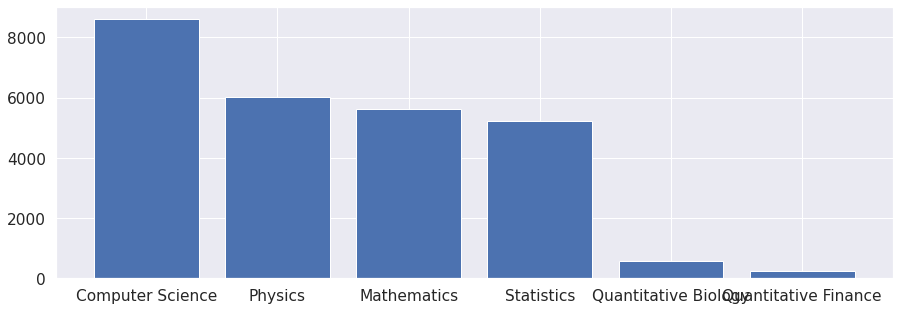

In [144]:
plt.figure(figsize=(15,5))
plt.bar(categories,category_count)



From the above plot its clear that "Quantitative biolgy" and "quantitative Finance" have too much less values, that means the dataset is imbalanced.

As the dataset is imbalanced, to make it balanced we can apply resampling techniques, the dataset is small so we can try oversampling of these two classes. 

we will implement oversampling later, first we will try to build a basic classification model.

now lets plot a figure for word count for each category.

In [145]:
total_word_count_in_each_category=[]
for i in categories:
  abstracts = train_df.where(train_df[i]==1)[['ABSTRACT']]
  count=pd.Series(abstracts.values.flatten()).str.len().sum()
  total_word_count_in_each_category.append(count)

<BarContainer object of 6 artists>

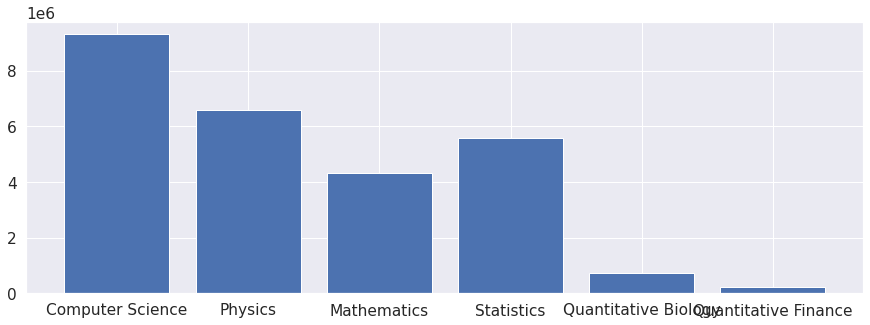

In [146]:
plt.figure(figsize=(15,5))
plt.bar(categories,total_word_count_in_each_category)

Word count also almost in the same proportion as the number of texts in each category, only difference is statistics has more word than mathematics even the number of articles are more for mathematics.







now lets analyze avg word length of abstract, for each category.

In [147]:
avg_abstract_len_for_each_category=[]
for i in range(6):
  avg_abstract_len_for_each_category.append(total_word_count_in_each_category[i]/category_count[i])

<BarContainer object of 6 artists>

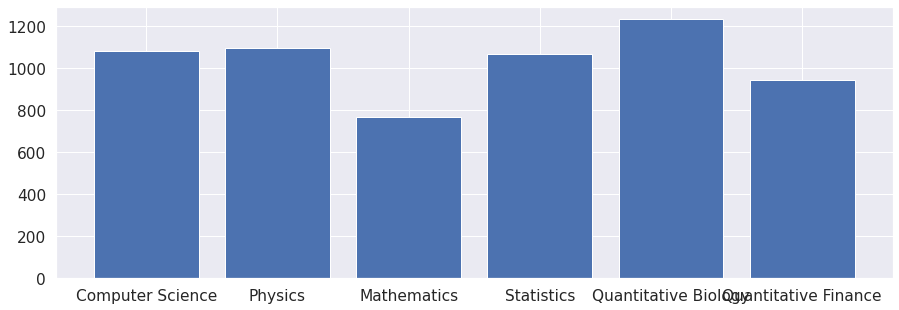

In [148]:


plt.figure(figsize=(15,5))
plt.bar(categories,avg_abstract_len_for_each_category)

From the above plot its clear that articles of quantitaive biology are longest, and mathematics articles are shortest.

For each category, how many abstracts contains numberic values ( I want to check:- is there any significant difference in number of abstracts of computer science and mathematics or statistics..etc based on which contains numeric values)

In [149]:
count_numeric_contained_texts=dict()
for category in categories:
    count_numeric_contained_texts[category]=0
    

In [150]:
count_numeric_contained_texts

{'Computer Science': 0,
 'Physics': 0,
 'Mathematics': 0,
 'Statistics': 0,
 'Quantitative Biology': 0,
 'Quantitative Finance': 0}

In [151]:
import re 

In [152]:
for category in categories:
    for text in train_df[train_df[category]==1]["ABSTRACT"]:
        if re.findall("\d",text):
            count_numeric_contained_texts[category]+=1 

In [153]:
for i in range(len(categories)):
    count_numeric_contained_texts[categories[i]]=count_numeric_contained_texts[categories[i]]/category_count[i]

In [154]:
count_numeric_contained_texts

{'Computer Science': 0.43146381196183387,
 'Physics': 0.6113420921337103,
 'Mathematics': 0.4855820576717693,
 'Statistics': 0.3907030349596619,
 'Quantitative Biology': 0.41737649063032367,
 'Quantitative Finance': 0.40963855421686746}

<BarContainer object of 6 artists>

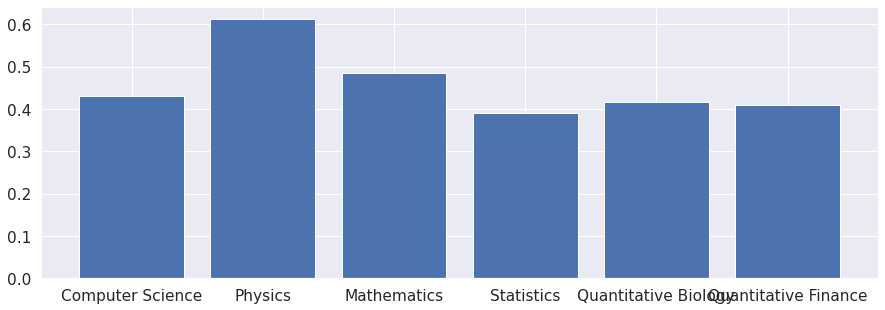

In [155]:
plt.figure(figsize=(15,5))
plt.bar(categories,count_numeric_contained_texts.values())

Each category have numeric values in almost 40% texts except physics, also physics doesnt have significant difference, so numeric values in abstracts doesnt add any significant difference between categories, so we will just remove the numeric values from text preprocessing step.

lets concatenate Title and Abstract, and make it one big text.

In [156]:
train_df["text"]=train_df["TITLE"]+" "+train_df["ABSTRACT"]

dropping the TITLE and ABSTRACT columns.

In [157]:
train_df.drop(["TITLE","ABSTRACT"],axis=1,inplace=True)

In [158]:
train_df.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text
0,1,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps ...
1,2,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation ...
2,3,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...
3,4,0,0,1,0,0,0,A finite element approximation for the stochas...
4,5,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...


Lets make a function for train test split that we will need further.

In [159]:
from sklearn.model_selection import train_test_split

In [160]:
def split(X,y,test_size):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size,random_state=42)
    return (X_train,X_test,y_train,y_test)



# **Cleaning the text**

Generally cleaning the text consists of two steps

1. Normalizing the text (lowercase the all words) , removing punctuations, removing unicode characters, removing stopwords etc.

2. Applying stemming or lemmatization on words.

i would apply lemmatization because the lemmatized words have more information than stemmed words yet stemming is faster than lemmatization.

There are 2 available libraries available for lemmatization 1.NLTK 2.Spacy

i will try from both, then will compare the result.

In [161]:
# cleaned_title1=[] #after cleaning the each row's title , it will be appended in this list.
# for i in range(train_df.shape[0]):#iterating through the whole dataset.
#     title=re.sub("\n"," ",train_df.text[i])#text contains "/n" each time when line changes so we have to remove them 
#     title=re.sub("[^a-zA-Z]+ "," ",title)# removing all characters other than a-z, A-Z, 0-9 and space
#     title=title.lower()#changing the texts into lowercase.
#     title=title.split()#it will give a list of words
#     title=[lemmatizer.lemmatize(word) for word in title if not word in stopwords.words("english")]#removing stopords and applying lemmatization.
#     title=" ".join(title)#.join() will return string of lemmatized words.
#     cleaned_title1.append(title)#cleaned text is appended into the list.


In [162]:
# Saving this n_corpus to a csv file so that we don't have run above cell every time because it is taking too much time
#import pandas as pd
# Create a local file to upload.
# df_ = pd.DataFrame(cleaned_title1)
# df_.to_csv("cleaned_text1.csv")

In [163]:
# df_.loc[0,0],train_df.text[0]


importing spacy library for lemmatizing the words and using regular expression we will clean the text(removing numeric characters and stopwards )

In [164]:
nlp=spacy.load("en_core_web_sm",disable=['ner','parser']) # disabling Named Entity Recognition for speed

In [165]:
brief_cleaning=(re.sub("[^a-zA-Z]+"," ",str(text)).lower() for text in train_df["text"])

In [166]:
def cleaning(doc):
    txt=[token.lemma_ for token in doc if not token.is_stop]
    txt=[txt for txt in txt if len(txt)>1]
    return " ".join(txt)

Taking advantage of spaCy .pipe() attribute to speed-up the cleaning process:

In [167]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=2000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 2.12 mins


In [168]:
train_df.text[9]

'$\\mathcal{R}_{0}$ fails to predict the outbreak potential in the presence of natural-boosting immunity   Time varying susceptibility of host at individual level due to waning and\nboosting immunity is known to induce rich long-term behavior of disease\ntransmission dynamics. Meanwhile, the impact of the time varying heterogeneity\nof host susceptibility on the shot-term behavior of epidemics is not\nwell-studied, even though the large amount of the available epidemiological\ndata are the short-term epidemics. Here we constructed a parsimonious\nmathematical model describing the short-term transmission dynamics taking into\naccount natural-boosting immunity by reinfection, and obtained the explicit\nsolution for our model. We found that our system show "the delayed epidemic",\nthe epidemic takes off after negative slope of the epidemic curve at the\ninitial phase of epidemic, in addition to the common classification in the\nstandard SIR model, i.e., "no epidemic" as $\\mathcal{R}_{0}\




we will store the cleaned text into a list

In [169]:
# cleaned_title2=[]
# for i in range(train_df.shape[0]):
#     title1=train_df.text[i]
#     title1=title1.lower().strip()
#     title1=re.sub("\n"," ",title1)
#     title1=re.sub("[^a-zA-Z0-9 +]"," ",title1)
#     title1=nlp(title1)
#     title1=[token.lemma_.strip() for token in title1 if (not token.is_stop) and (len(token)>1)]
#     title1=" ".join(title1)
#     title1=re.sub(" +"," ",title1)
#     cleaned_title2.append(title1)

In [170]:
# cleaned_title1[0]

In [171]:
# len(cleaned_title2)

Spacy does better lemmatization than NLTK, so we will use cleaned_text2 to make our model

In [172]:
# Saving this cleaned text to a csv file so that we don't have run above cell every time because it is time taking
# import pandas as pd
# # Create a local file to upload.
# df1 = pd.DataFrame(cleaned_title2)
# df1.to_csv("cleaned_text_2.csv")

In [173]:
cleaned_text=pd.read_csv("../input/cleaned-text-s/cleaned_text_2.csv")
cleaned_text=list(cleaned_text['0'].values)
cleaned_text[:3]

['reconstruct subject specific effect map predictive model allow subject specific inference analyze disease relate alteration neuroimage datum give subject data inference level global identifiye condition presence subject local detect condition effect individual measurement extract subject datum global inference widely local inference form subject specific effect map rarely exist model yield noisy detection compose disperse isolate island article propose reconstruction method name rsm improve subject specific detection predictive modeling approach particular binary classifier rsm specifically aim reduce noise sampling error associate finite sample example train classifier propose method wrapper type algorithm different binary classifier diagnostic manner information condition presence reconstruction pose maximum posteriori problem prior model parameter estimate train datum classifier specific fashion experimental evaluation perform synthetically generate datum datum alzheimer disease n

In [174]:
len(txt)

20972

To create the vocabulary, we will join all the texts.

In [175]:
vocabulary=" ".join(txt)
x=set(vocabulary.split())
len(x)

44210

In [176]:
train_df.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text
0,1,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps ...
1,2,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation ...
2,3,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...
3,4,0,0,1,0,0,0,A finite element approximation for the stochas...
4,5,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...


There are total 45593 unique words in all the articles and only those we will use into our model.

In [177]:
train_df['cleaned_text']=txt
train_df.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text,cleaned_text
0,1,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps ...,reconstruct subject specific effect map predic...
1,2,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation ...,rotation invariance neural network rotation in...
2,3,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...,spherical polyharmonics poisson kernel polyhar...
3,4,0,0,1,0,0,0,A finite element approximation for the stochas...,finite element approximation stochastic maxwel...
4,5,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...,comparative study discrete wavelet transform w...


In [178]:
train_df.cleaned_text[0]

'reconstruct subject specific effect map predictive model allow subject specific inference analyze disease relate alteration neuroimage datum give subject datum inference level global identifiye condition presence subject local detect condition effect individual measurement extract subject datum global inference widely local inference form subject specific effect map rarely exist model yield noisy detection compose disperse isolate island article propose reconstruction method name rsm improve subject specific detection predictive modeling approach particular binary classifier rsm specifically aim reduce noise sampling error associate finite sample example train classifier propose method wrapper type algorithm different binary classifier diagnostic manner information condition presence reconstruction pose maximum posteriori problem prior model parameter estimate train datum classifier specific fashion experimental evaluation perform synthetically generate datum datum alzheimer disease n

In [179]:
X_train,X_test,y_train,y_test=split(train_df.loc[:,"cleaned_text"],train_df.loc[:,categories],0.2)

In [180]:

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((16777,), (4195,), (16777, 6), (4195, 6))

In [181]:
y_train

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
16466,0,0,0,0,0,1
4021,0,0,1,0,0,0
17248,1,0,0,0,0,0
17239,0,1,0,0,0,0
2966,0,1,0,0,0,0
...,...,...,...,...,...,...
11284,0,0,0,1,0,0
11964,0,1,0,0,0,0
5390,0,1,0,0,0,0
860,1,0,0,0,0,0


In [182]:

y_test=y_test.idxmax(axis='columns')
y_train=y_train.idxmax(axis='columns')

In [183]:
y_test

20257        Computer Science
482               Mathematics
4189         Computer Science
9838                  Physics
16591        Computer Science
                 ...         
14740             Mathematics
3755     Quantitative Biology
10684             Mathematics
16274                 Physics
14452        Computer Science
Length: 4195, dtype: object

In [184]:

le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.transform(y_test)

In [185]:
y_train,y_test

(array([4, 1, 0, ..., 2, 0, 0]), array([0, 1, 0, ..., 1, 2, 0]))






# **Changing text into numericals using Tfidf technique**

In [186]:
tfv=TfidfVectorizer(min_df=3,max_features=30000,strip_accents="unicode",analyzer="word",token_pattern=r"\w{1,}",ngram_range=(1,3),use_idf=1,smooth_idf=1,sublinear_tf=1,stop_words="english")

In [187]:
def tfidf_vectors(X_train,X_test):
    tfv.fit(list(X_train)+list(X_test))
    xtrain_tfv=tfv.transform(X_train)
    xtest=tfv.transform(X_test)
    return xtrain_tfv,xtest
xtrain_tfv,xtest=tfidf_vectors(X_train,X_test)

In [188]:
xtrain_tfv.shape

(16777, 30000)

Target columns has 6 columns , so lets change into one columns which will have all 6 different categories.

In [189]:
y_train_new=y_train
y_test_new=y_test

**Lest apply a simple LogisticRegression model to classify.**

In [190]:
def clf_(xtrain_tfv,y_train_new,C):
    clf=LogisticRegression(C=C,solver="sag")
    clf.fit(xtrain_tfv,y_train_new)
    return clf
clf=clf_(xtrain_tfv,y_train_new,1.0)

Apply grid search to optimize the hyperparameters.

In [191]:


# from sklearn.model_selection import GridSearchCV
# params={
#     'C':[0.1,0.3,0.5,0.8,1],
#     'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#     'penalty':['l1', 'l2', 'elasticnet', 'none']
# }
# gs_knn = GridSearchCV(LogisticRegression(),
#                       param_grid=params,
#                       scoring='accuracy',
#                       cv=5)

# gs_model = gs_knn.fit(X_train_vect_avg, y_train.values.ravel())

In [192]:
#gs_model.best_params_

In [193]:
clf=clf=clf_(xtrain_tfv,y_train_new,1.2)
clf

LogisticRegression(C=1.2, solver='sag')

In [194]:
train_preds=clf.predict(xtrain_tfv)
test_preds=clf.predict(xtest)
train_preds

array([0, 1, 0, ..., 2, 0, 0])


**Accuracy metric**

Our dataset is imbalanced and all the classes are equally important, so for this case macro average f1 score would be the best, and the confusion matric would give the overall good picture of every class's prediction.

In [195]:
print("train",f1_score(y_train_new,clf.predict(xtrain_tfv),average='macro'))
print("test",f1_score(y_test_new,clf.predict(xtest),average="macro"))

train 0.769456244440131
test 0.580410285186503


We can clearly see that the model is failing to generalize the test data so we need to apply some complex models.

In [196]:
print("train_accuracy",accuracy_score(y_train_new,clf.predict(xtrain_tfv)))
print("test_accuracy",accuracy_score(y_test_new,clf.predict(xtest)))

train_accuracy 0.8985515884842343
test_accuracy 0.8100119189511323


In [197]:
def plot_confusion_matrix(y,y_preds):
    c_matrix=confusion_matrix(y,y_preds)

    c_matrix=pd.DataFrame(c_matrix,columns=['Computer Science',
     'Physics',
     'Mathematics',
     'Statistics',
     'Quantitative Biology',
     'Quantitative Finance'],index=['Computer Science',
     'Physics',
     'Mathematics',
     'Statistics',
     'Quantitative Biology',
     'Quantitative Finance'])

    fig,ax=plt.subplots(figsize=(12,12))
    sns.set(font_scale=1.4)
    sns.heatmap(c_matrix/np.sum(c_matrix),fmt="0.2%",annot=True,cmap="Blues",ax=ax)
    ax.set_title("Confusion matrix ",fontsize=26)
    ax.set_xlabel("Predicted",fontsize=26)
    ax.set_ylabel("Actual",fontsize=26)


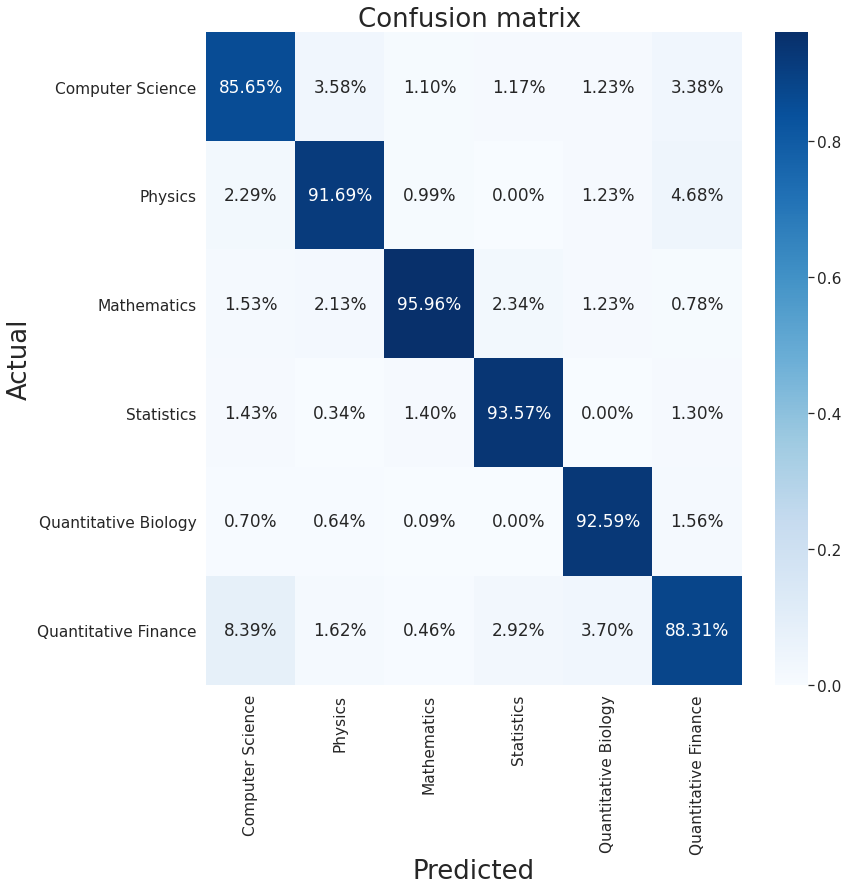

In [198]:
plot_confusion_matrix(y_train_new,clf.predict(xtrain_tfv))

From the confusion matrix, its clear that our machine learning model is not able to classify two classes accurately 

1.computer science-  it has the most number of the texts, so a ml model should classify it more accurately than others that instead of that it has low accuracy that means this category text has some noise.

2.Quantitative finance- it has lowest number of text so thats why our ml model is not classifying it accurately so for this we can apply oversampling.


lets now apply other techniques first, after we will modify our text and will apply oversampling.

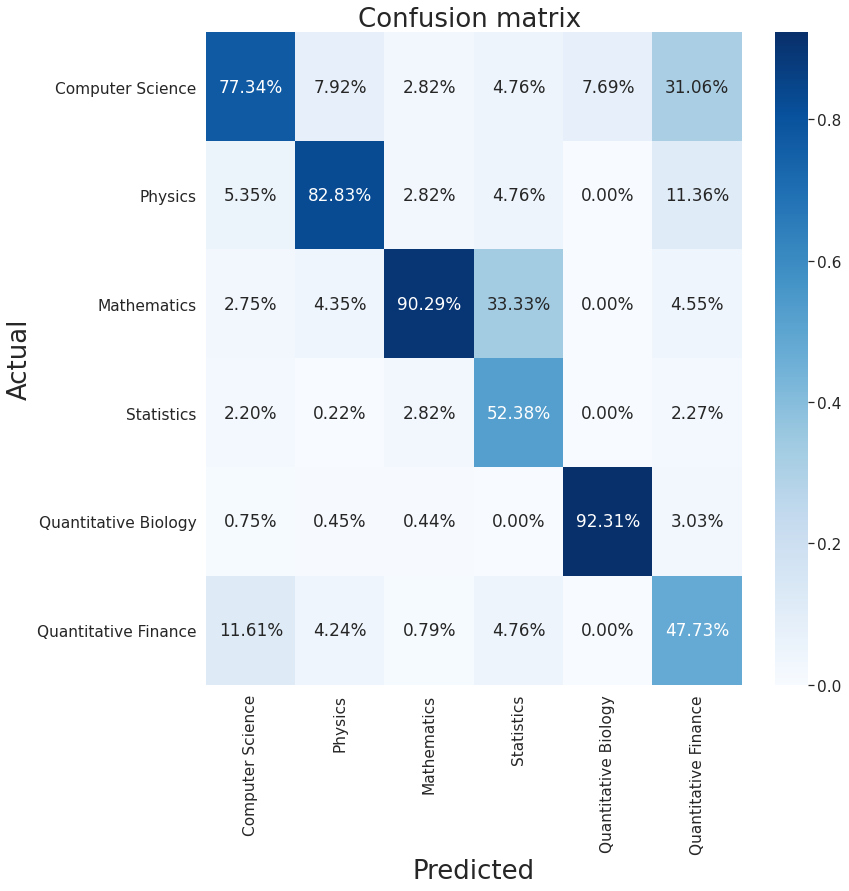

In [199]:
plot_confusion_matrix(y_test_new,clf.predict(xtest))

From the confusion matrix,its very clear that ML model finding it difficult to differenciate between maths and stats, and due to less number of rows of Quantitative finance, ML model didnt learn it properly so we didnt get the good accuracy for this class.

Using a pipeline, we can do this task more organised and it is very easy to implement a new machine learning model(lets apply multinomial NB) with pipeline.

In [200]:

tfidf_pipeline=Pipeline([("tfidf",TfidfVectorizer(min_df=3,max_features=30000,strip_accents="unicode",analyzer="word",token_pattern=r"\w{1,}",ngram_range=(1,2),use_idf=1,smooth_idf=1,sublinear_tf=1,stop_words="english"))])

tfidf_pipeline.fit_transform(X_train)
tfidf_pipeline.transform(X_test)

lg_regression_pipeline=Pipeline([("tfidf_pipeline",tfidf_pipeline),
                        ("clf",LogisticRegression(C=1,solver="sag"))])



lg_regression_pipeline.fit(X_train,y_train_new)

lg_regression_pipeline.predict(X_train)

array([0, 1, 0, ..., 2, 0, 0])

In [201]:
print("macro_f1_score_train",f1_score(y_train_new,lg_regression_pipeline.predict(X_train),average="macro"))
print("macro_f1_score_test",f1_score(y_test_new,lg_regression_pipeline.predict(X_test),average='macro'))

macro_f1_score_train 0.7356873177198806
macro_f1_score_test 0.5813266927174946


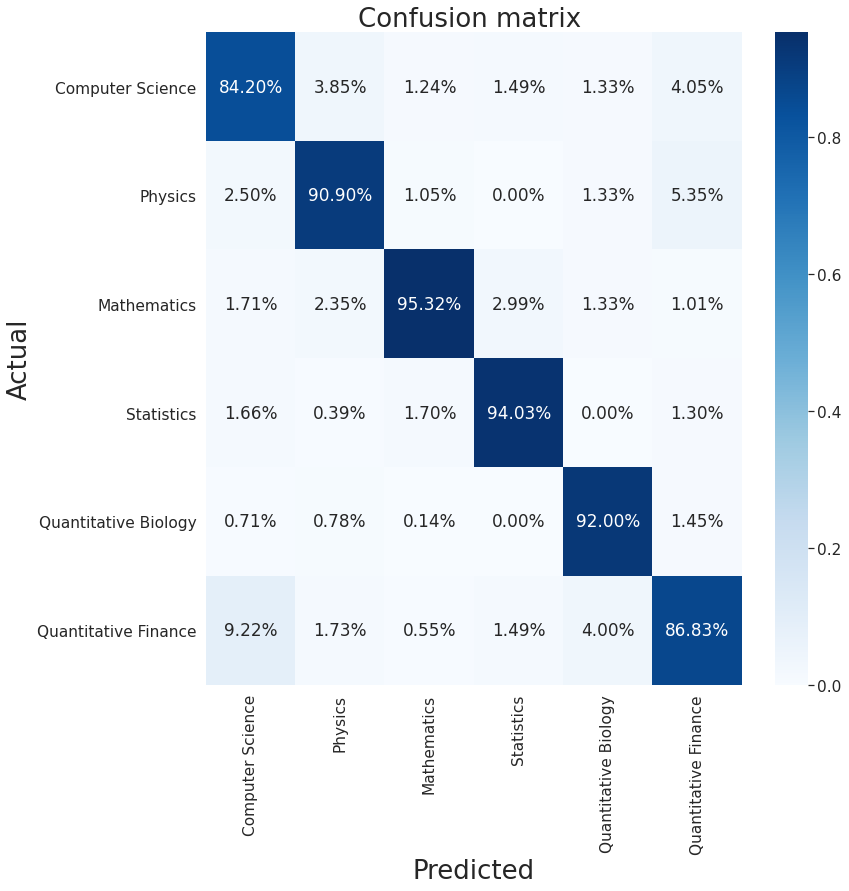

In [202]:
plot_confusion_matrix(y_train_new,lg_regression_pipeline.predict(X_train))


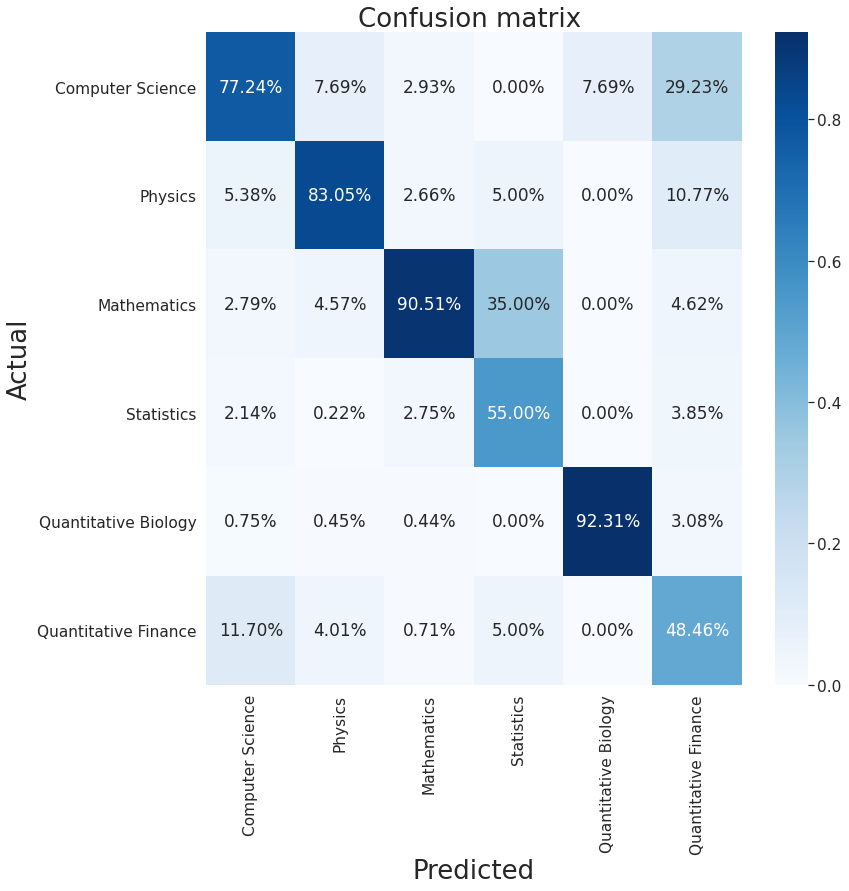

In [203]:
plot_confusion_matrix(y_test_new,lg_regression_pipeline.predict(X_test))

In [204]:
mnb_regression_pipeline=Pipeline([("tfidf_pipeline",tfidf_pipeline),
                        ("mnb",MultinomialNB())])
mnb_regression_pipeline.fit(X_train,y_train_new)





Pipeline(steps=[('tfidf_pipeline',
                 Pipeline(steps=[('tfidf',
                                  TfidfVectorizer(max_features=30000, min_df=3,
                                                  ngram_range=(1, 2),
                                                  smooth_idf=1,
                                                  stop_words='english',
                                                  strip_accents='unicode',
                                                  sublinear_tf=1,
                                                  token_pattern='\\w{1,}',
                                                  use_idf=1))])),
                ('mnb', MultinomialNB())])

In [205]:
print("macro_f1_score_train",f1_score(y_train_new,mnb_regression_pipeline.predict(X_train),average="macro"))
print("macro_f1_score_test",f1_score(y_test_new,mnb_regression_pipeline.predict(X_test),average='macro'))

macro_f1_score_train 0.43832665436652896
macro_f1_score_test 0.41953092357140886


We just need to copy-paste the code, and change the model name, and we applied a new model on the data.

# Changing words into vector using genism

In [206]:
w2v_model=Word2Vec(min_count=2,
                  window=2,
                  size=200,
                  sample=6e-5,
                  alpha=0.03,
                  min_alpha=0.0007,
                  negative=20)

In [207]:
sent=[text.split() for text in train_df["cleaned_text"]]
sent[0]

['reconstruct',
 'subject',
 'specific',
 'effect',
 'map',
 'predictive',
 'model',
 'allow',
 'subject',
 'specific',
 'inference',
 'analyze',
 'disease',
 'relate',
 'alteration',
 'neuroimage',
 'datum',
 'give',
 'subject',
 'datum',
 'inference',
 'level',
 'global',
 'identifiye',
 'condition',
 'presence',
 'subject',
 'local',
 'detect',
 'condition',
 'effect',
 'individual',
 'measurement',
 'extract',
 'subject',
 'datum',
 'global',
 'inference',
 'widely',
 'local',
 'inference',
 'form',
 'subject',
 'specific',
 'effect',
 'map',
 'rarely',
 'exist',
 'model',
 'yield',
 'noisy',
 'detection',
 'compose',
 'disperse',
 'isolate',
 'island',
 'article',
 'propose',
 'reconstruction',
 'method',
 'name',
 'rsm',
 'improve',
 'subject',
 'specific',
 'detection',
 'predictive',
 'modeling',
 'approach',
 'particular',
 'binary',
 'classifier',
 'rsm',
 'specifically',
 'aim',
 'reduce',
 'noise',
 'sampling',
 'error',
 'associate',
 'finite',
 'sample',
 'example',
 'tra

In [208]:
phrases=Phrases(sent,min_count=20,progress_per=2000)

In [209]:
bigram=Phraser(phrases)
bigram

In [210]:
sentences=bigram[sent]

In [211]:
sentences

In [212]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

45912

In [213]:
sorted(word_freq,key=word_freq.get,reverse=True)[:10]

['model',
 'method',
 'base',
 'system',
 'result',
 'network',
 'datum',
 'problem',
 'algorithm',
 'approach']

In [214]:
sorted(word_freq, key=word_freq.get, reverse=False)[:10]

['identifiye',
 'polyharmonics',
 'hua',
 'obstacles',
 'lowell',
 'reinfection',
 'refracture',
 'proverb',
 'cdmnse',
 'cdmgse']

In [215]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.19 mins


In [216]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 4.76 mins


In [217]:
w2v_model.wv.most_similar("computer")

[('microhydrodynamic', 0.5376343727111816),
 ('chess', 0.461262583732605),
 ('annealer', 0.4601186513900757),
 ('eyewear', 0.4600115716457367),
 ('verdict', 0.4581140875816345),
 ('laptop', 0.4486352801322937),
 ('archaeologist', 0.4309203028678894),
 ('simulink', 0.4255560636520386),
 ('metadynamic', 0.42524832487106323),
 ('scientist', 0.41916385293006897)]

In [218]:
w2v_model.wv["biology"]

array([-0.42317295,  0.6592974 ,  0.80535954, -0.24033494,  1.3495085 ,
       -0.35969177,  0.4233542 ,  0.11754769, -0.84651524, -0.04036793,
       -0.03752451, -0.06640983,  0.4709173 , -0.36061567, -1.1216384 ,
        1.1199853 ,  0.49801907,  0.08840987,  0.1439971 ,  0.26259097,
       -1.2043024 ,  0.48044807,  0.21957207, -0.8830412 ,  0.71042866,
        1.4006994 ,  1.1553918 , -0.51993936,  1.1340503 , -0.2627541 ,
        0.7002114 ,  0.11908107, -0.2468479 ,  0.11030297,  0.47843614,
        0.35163274, -0.42225394,  0.43949637,  0.30742115,  0.1016205 ,
        1.005015  ,  0.20836155,  0.44817895,  0.65540385,  0.34722555,
       -0.0383657 ,  0.8031047 ,  0.17197798,  0.3529505 ,  0.21188302,
       -0.81078994, -0.21644187,  0.02996415,  0.85733974, -1.3618432 ,
        0.59884965,  0.92218703, -0.7267155 , -0.02746945, -0.19867302,
       -0.9511665 , -0.6014693 , -0.42547807,  1.0073816 ,  0.4091709 ,
        0.36882204,  0.8523977 , -0.07632713,  0.36255473,  1.26

In [219]:
w2v_model.wv.most_similar(positive=["biology"])

[('social_science', 0.6487641334533691),
 ('electrochemistry', 0.6162095665931702),
 ('recapitulate', 0.6075472831726074),
 ('biologist', 0.5918365716934204),
 ('epidemiology', 0.5908939242362976),
 ('sciences', 0.5700903534889221),
 ('ecology', 0.558141827583313),
 ('anthropology', 0.5538387894630432),
 ('neuroscience', 0.5513860583305359),
 ('physiology', 0.5477084517478943)]

In [220]:
w2v=dict(zip(w2v_model.wv.index2word,w2v_model.wv.syn0))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [221]:
len(w2v['model'])

200

In [222]:
X_train

16466    reverse quantum anneal approach portfolio opti...
4021     arithmetic property polynomial paper prove dio...
17248    latte application orient social network embed ...
17239    momentum energy resolve spectral function elec...
2966     collisional dynamic soliton couple pt symmetri...
                               ...                        
11284    tensor method nonlinear matrix completion low ...
11964    numerical simulation collisional cascade roche...
5390     possible evidence spin transfer torque induce ...
860      common knowledge logic gossip gossip protocol ...
15795    trust base collaborative filter tackle cold st...
Name: cleaned_text, Length: 16777, dtype: object

In [223]:
train_mean_word_vectors=[]
for i in X_train:
    words=i.split()
    train_mean_word_vectors.append(np.mean([w2v[word] for word in words if word in w2v]
                      or np.zeros(200),axis=0))

In [224]:
test_mean_word_vectors=[]
for i in X_test:
    words=i.split()
    test_mean_word_vectors.append(np.mean([w2v[word] for word in words if word in w2v]
                      or np.zeros(200),axis=0))

In [225]:
train_mean_word_vectors[0],test_mean_word_vectors[0]

(array([-2.00660512e-01, -9.98271108e-02,  7.45412707e-02, -7.29399640e-03,
         2.30854861e-02, -1.48915693e-01,  1.09455036e-02,  1.30413607e-01,
        -2.31497154e-01, -1.57765925e-01, -2.49212980e-02, -5.75631857e-02,
         1.06552780e-01, -3.33503544e-01, -3.99201781e-01, -2.55530804e-01,
         1.23249762e-01, -2.64267504e-01, -2.06884965e-02,  1.39671974e-02,
        -2.34603122e-01, -2.32775807e-02, -2.38754734e-01, -1.40528873e-01,
        -1.64463729e-01, -5.44237196e-02,  1.22750953e-01, -1.54942871e-04,
        -2.00675622e-01, -2.01682642e-01,  6.14610799e-02,  2.26812020e-01,
        -2.21212313e-01,  2.32785687e-01, -1.63895488e-02, -4.85926047e-02,
        -5.95031343e-02,  5.46734817e-02, -1.22380391e-01,  2.29556173e-01,
         8.65348801e-02,  2.37693653e-01, -4.10537831e-02,  1.20536521e-01,
         3.86171183e-03,  4.09929053e-04,  1.62397310e-01,  2.11199984e-01,
        -2.36402974e-02,  2.04141349e-01, -1.01199940e-01, -3.51706117e-01,
        -1.7

In [226]:
df_mean_word_vectors=pd.DataFrame(train_mean_word_vectors,columns=range(1,201))
df_mean_word_vectors_test=pd.DataFrame(test_mean_word_vectors,columns=range(1,201))

In [227]:
df_mean_word_vectors

,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
0,-0.200661,-0.099827,0.074541,-0.007294,0.023085,-0.148916,0.010946,0.130414,-0.231497,-0.157766,...,0.185522,0.167503,0.056122,-0.081481,0.006947,-0.297937,0.030923,-0.139525,0.034117,-0.176495
1,0.367867,-0.125517,-0.280987,-0.292608,0.102502,0.235660,0.465701,0.139796,-0.063963,-0.040378,...,0.395100,0.399299,0.191850,-0.123641,-0.309354,-0.423375,-0.000137,-0.067717,0.296156,0.247787
2,-0.054786,-0.347223,0.090402,0.034948,-0.187923,-0.457208,0.069448,0.091595,-0.131851,-0.081152,...,-0.127853,-0.118224,-0.084608,0.274607,0.239208,-0.273655,0.192569,-0.167316,0.117990,-0.294663
3,-0.145983,0.103815,0.032136,-0.095652,-0.113767,-0.304876,0.241679,-0.329586,-0.037288,-0.381544,...,0.322937,0.281076,-0.249832,-0.186802,0.103575,-0.162471,-0.050601,-0.006398,-0.003000,-0.109180
4,-0.058744,-0.298196,0.023743,0.013030,0.010623,-0.164176,0.244137,0.006533,0.131788,-0.299662,...,0.158608,0.384109,0.108415,-0.218030,0.017489,-0.151061,-0.006559,0.059929,0.149123,-0.231941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,-0.056055,-0.249783,-0.078536,-0.154328,-0.149274,-0.308603,0.079478,-0.002011,-0.011201,0.068872,...,0.015742,0.271701,0.042718,0.079273,-0.009060,-0.198054,0.198540,-0.341493,0.173652,-0.066220
16773,-0.095101,-0.106759,0.143306,-0.093847,0.028436,0.029511,0.115133,0.112314,0.001092,-0.425114,...,0.496143,0.036536,0.131048,-0.267280,-0.190425,-0.090803,-0.015348,0.185974,0.033934,-0.222000
16774,0.216705,0.181238,0.159545,-0.415937,-0.160877,-0.312082,0.247065,-0.106544,-0.066494,-0.381351,...,0.152192,0.263184,0.014486,-0.198964,0.176507,-0.426057,0.096456,-0.067060,-0.316626,0.038975
16775,0.040378,0.112395,-0.012057,-0.125940,-0.339484,-0.396000,0.258869,0.088605,-0.402327,-0.112089,...,-0.135056,0.199316,-0.181613,0.182969,-0.031924,-0.458311,0.179021,-0.435663,0.171277,-0.073496


In [228]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler


In [229]:
y_train_new

array([4, 1, 0, ..., 2, 0, 0])

In [230]:
# applying labelencoder
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y_train=le.fit_transform(y_train_new)
y_train

array([4, 1, 0, ..., 2, 0, 0])

In [231]:
y_test_new

array([0, 1, 0, ..., 1, 2, 0])

In [232]:
y_test=le.transform(y_test_new)
y_test

array([0, 1, 0, ..., 1, 2, 0])

In [233]:
X_train=df_mean_word_vectors
X_test=df_mean_word_vectors_test
X_train=X_train.values
X_train

array([[-0.20066051, -0.09982711,  0.07454127, ..., -0.13952492,
         0.03411701, -0.17649534],
       [ 0.3678672 , -0.12551719, -0.2809867 , ..., -0.06771672,
         0.29615599,  0.2477866 ],
       [-0.05478635, -0.34722281,  0.09040165, ..., -0.16731592,
         0.11798985, -0.29466295],
       ...,
       [ 0.2167054 ,  0.18123791,  0.15954532, ..., -0.06706039,
        -0.3166261 ,  0.03897454],
       [ 0.04037825,  0.11239509, -0.01205692, ..., -0.43566319,
         0.17127696, -0.07349635],
       [ 0.13175304, -0.41008222, -0.09235902, ..., -0.15440948,
         0.13980617, -0.36227977]])

In [234]:
X_test=X_test.values
X_test

array([[ 0.05696571, -0.30187824, -0.08407115, ...,  0.05846018,
        -0.06894159, -0.38226143],
       [-0.00418459, -0.1901383 ,  0.08338545, ..., -0.52961558,
        -0.03104214,  0.04766908],
       [-0.0740629 , -0.06187984,  0.09495358, ..., -0.13287604,
         0.16256543, -0.25672996],
       ...,
       [-0.025257  , -0.35287541, -0.26297802, ..., -0.00246959,
         0.14889798,  0.03593156],
       [-0.03361543,  0.10858093,  0.08688135, ...,  0.00192756,
        -0.24732353, -0.29943991],
       [ 0.26770493, -0.18354525,  0.0531617 , ..., -0.0158111 ,
        -0.07685457, -0.33145884]])

In [235]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
# val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [236]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list

tensor([4, 1, 0,  ..., 2, 0, 0])

In [237]:
def get_class_distribution(obj):
    count_dict = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict[0] += 1
        elif i == 1: 
            count_dict[1] += 1
        elif i == 2: 
            count_dict[2] += 1
        elif i == 3: 
            count_dict[3] += 1
        elif i == 4: 
            count_dict[4] += 1  
        elif i == 5: 
            count_dict[5] += 1              
        else:
            print("Check classes.")
            
    return count_dict

In [238]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.0001, 0.0003, 0.0002, 0.0028, 0.0059, 0.0007])


In [239]:
class_weights_all = class_weights[target_list]
class_weights_all

tensor([0.0059, 0.0003, 0.0001,  ..., 0.0002, 0.0001, 0.0001])

In [240]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [241]:
EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(df_mean_word_vectors.columns)
NUM_CLASSES = 6

In [242]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
# val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [243]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [244]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [245]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)


MulticlassClassification(
  (layer_1): Linear(in_features=200, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [246]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [247]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [248]:
val_loader=test_loader

In [249]:
# pip install torchmetrics

In [250]:
# from torchmetrics.classification import MulticlassF1Score
# metric = MulticlassF1Score(num_classes=6)

In [251]:
# def metric(y_train_pred,y_train_batch):
#     print(y_train_pred,y_train_batch)
#     for i in range(len(y_train_pred)):
#         if y_train_pred[i]==y_ytrain_batch[i]:
#             acc+=1
#     return acc/len(y_train_pred)

In [252]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc


In [253]:
from tqdm.notebook import tqdm
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()

        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))


    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 001: | Train Loss: 0.32332 | Val Loss: 1.27221 | Train Acc: 65.728| Val Acc: 53.468
Epoch 002: | Train Loss: 0.20558 | Val Loss: 1.17428 | Train Acc: 73.926| Val Acc: 56.496
Epoch 003: | Train Loss: 0.17294 | Val Loss: 1.13274 | Train Acc: 75.830| Val Acc: 57.187
Epoch 004: | Train Loss: 0.15979 | Val Loss: 0.99993 | Train Acc: 76.985| Val Acc: 61.836
Epoch 005: | Train Loss: 0.14144 | Val Loss: 1.05575 | Train Acc: 79.027| Val Acc: 59.166
Epoch 006: | Train Loss: 0.13510 | Val Loss: 0.98570 | Train Acc: 78.805| Val Acc: 60.882
Epoch 007: | Train Loss: 0.11647 | Val Loss: 0.94895 | Train Acc: 80.275| Val Acc: 64.029
Epoch 008: | Train Loss: 0.12576 | Val Loss: 0.96419 | Train Acc: 80.173| Val Acc: 62.908
Epoch 009: | Train Loss: 0.10804 | Val Loss: 0.98184 | Train Acc: 80.956| Val Acc: 61.192
Epoch 010: | Train Loss: 0.11108 | Val Loss: 0.96152 | Train Acc: 81.025| Val Acc: 63.075
Epoch 011: | Train Loss: 0.10874 | Val Loss: 1.03125 | Train Acc: 81.053| Val Acc: 60.000
Epoch 012:

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

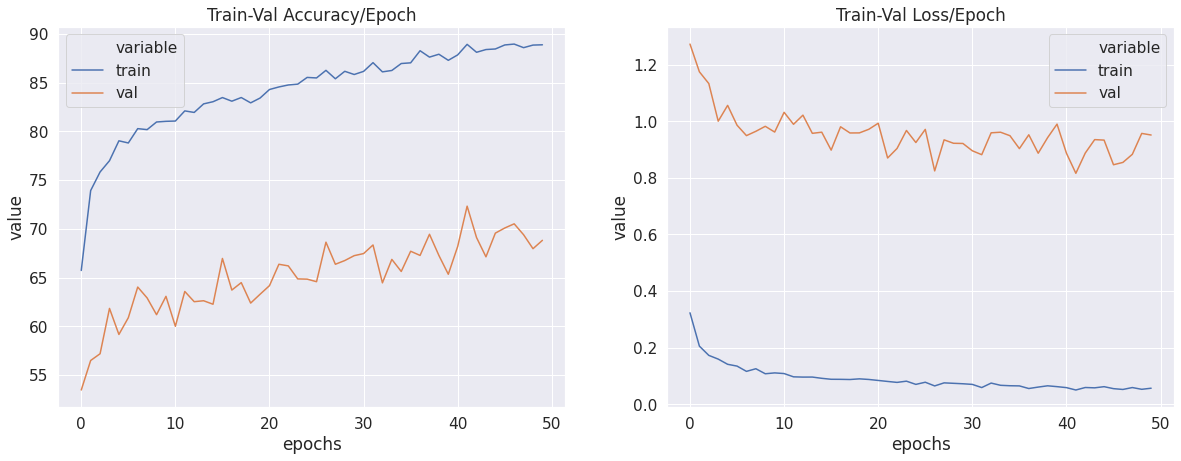

In [254]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

# **DOC2VEC**

In [255]:
X_train,X_test,y_train,y_test=split(train_df.loc[:,"cleaned_text"],train_df.loc[:,categories],0.2)


In [256]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((16777,), (4195,), (16777, 6), (4195, 6))

In [257]:
y_test=y_test.idxmax(axis='columns')
y_train=y_train.idxmax(axis='columns')


In [258]:
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.transform(y_test)

In [259]:
list_of_list_of_words_train=[sent.split(" ") for sent in X_train]
list_of_list_of_words_test=[sent.split(" ") for sent in X_test]



In [260]:
def tagged_document(list_of_list_of_words):
    for i,list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words,[i])
training_data=list(tagged_document(list_of_list_of_words_train))

In [261]:
model=gensim.models.doc2vec.Doc2Vec(vector_size=100,min_count=2,epochs=30)


In [262]:
model.build_vocab(training_data)


In [263]:
model.train(training_data, total_examples=model.corpus_count, epochs=model.epochs)

In [264]:
v=model.infer_vector
v

<bound method Doc2Vec.infer_vector of <gensim.models.doc2vec.Doc2Vec object at 0x7f37639339d0>>

In [265]:
def change_into_vector(doc):
    return model.infer_vector(doc)

In [266]:
train_doc_vectors=[]
for doc in list_of_list_of_words_train:
    train_doc_vectors.append(model.infer_vector(doc))

In [267]:
train_doc_vectors=np.array(train_doc_vectors)

In [268]:
train_doc_vectors=pd.DataFrame(train_doc_vectors,columns=range(1,101))

In [269]:
test_doc_vectors=[]
for doc in list_of_list_of_words_test:
    test_doc_vectors.append(model.infer_vector(doc))

In [270]:

test_doc_vectors=np.array(test_doc_vectors)
test_doc_vectors

array([[ 1.0125602 , -0.5051351 , -1.0009649 , ...,  0.43286058,
        -0.03348351,  0.8350001 ],
       [-0.744768  ,  1.2216548 ,  0.21911806, ...,  0.61253625,
        -2.193102  ,  1.1499877 ],
       [-0.2204972 ,  0.07893473,  1.06899   , ...,  0.15885775,
        -1.9957494 ,  0.7297652 ],
       ...,
       [-0.26787722,  0.77377445,  0.4661431 , ...,  1.073986  ,
        -0.17987137,  0.3154144 ],
       [ 1.2018539 , -0.7906277 ,  0.4370163 , ...,  0.22878124,
         0.6570713 ,  0.06737634],
       [-1.2103721 ,  1.024432  , -0.06585636, ..., -1.104362  ,
        -0.03102913,  0.38944992]], dtype=float32)

In [271]:
test_doc_vectors=pd.DataFrame(test_doc_vectors,columns=range(1,101))

In [272]:

test_doc_vectors.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,1.012560,-0.505135,-1.000965,-1.308620,0.164169,0.135899,0.465715,-0.947112,-0.675091,0.875849,...,-3.173724,0.549610,2.050263,0.311343,-0.986845,0.089976,0.188558,0.432861,-0.033484,0.835000
1,-0.744768,1.221655,0.219118,-1.348855,-0.709010,-0.309371,-0.158240,-0.482822,0.619591,0.338136,...,-0.114829,0.156877,-1.323351,1.093088,1.545646,-0.130346,-0.303351,0.612536,-2.193102,1.149988
2,-0.220497,0.078935,1.068990,0.317857,1.260801,0.004505,-1.400783,-0.940937,-0.149950,0.576986,...,-0.671778,1.796277,0.189832,0.288862,1.651351,0.480794,-0.619512,0.158858,-1.995749,0.729765
3,0.292494,-0.633954,0.593963,0.095490,0.012970,-0.937422,0.214338,1.111376,-0.589625,-1.108705,...,-0.595496,0.218042,0.812413,-0.502457,0.484317,-0.116288,-0.114213,-0.382819,-0.179622,0.425433
4,0.036016,-1.295776,1.017924,1.327914,-0.847154,-0.841518,-1.124557,0.736688,-1.069884,0.293448,...,-0.899816,0.784684,-0.312746,-0.946551,0.657996,0.063912,-1.088436,0.014945,1.563670,0.321061


In [273]:
from torch.utils.data import Dataset, DataLoader
class Data(Dataset):
    def __init__(self,X_train,Y_train):
        self.X=torch.from_numpy(X_train).float()
        self.Y=torch.from_numpy(Y_train).long()
        self.len=self.X.shape[0]
    def __getitem__(self,index):      
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len

In [274]:
train_doc_vectors=np.array(train_doc_vectors)
test_doc_vectors=np.array(test_doc_vectors)


In [275]:
train_data=Data(train_doc_vectors,y_train)
test_data=Data(test_doc_vectors,y_test)

In [276]:
train_data.X[0:5],train_data.Y[0:5]

(tensor([[ 1.5173e+00, -6.4468e-01,  2.1526e-01,  7.6008e-01,  7.7958e-01,
           6.7307e-01, -1.4627e+00, -1.3410e+00,  1.7697e-01, -5.8210e-01,
          -5.7830e-01,  7.7517e-01,  4.4636e-01,  1.0571e+00, -1.6920e+00,
          -3.7842e-01,  4.5507e-01, -4.5232e-01,  6.3072e-01,  1.2400e+00,
           1.0170e+00, -2.0706e-01, -1.9499e+00,  1.2588e+00, -7.1651e-01,
          -5.2451e-01, -2.2085e-01, -2.7475e-01, -1.5871e+00,  1.0540e-01,
           3.4276e-02,  6.9424e-01, -7.6126e-01,  8.6881e-01,  1.2820e+00,
          -3.3140e-01, -1.7985e-01,  1.2411e+00,  7.5781e-02,  5.7801e-01,
          -2.9630e-01,  1.4961e-01, -8.0107e-01,  4.2061e-01,  1.6095e+00,
           2.5864e-01,  9.9987e-01,  1.8004e+00,  9.5538e-01,  8.8507e-01,
          -1.0126e+00, -1.1623e+00, -5.3293e-01, -4.5949e-01, -3.8641e-01,
          -5.3245e-01, -5.9654e-01,  5.8519e-01,  1.1377e+00,  6.5660e-01,
          -4.8197e-02,  8.3904e-01, -1.3634e+00, -7.1449e-01,  1.2629e-01,
           3.1968e-01,  3

In [277]:
import torch.nn as nn
class NN(nn.Module):
    def __init__(self,input_layer,input_layer1,Hidder_layer,Hidden_layer2,output):
        super(NN,self).__init__()
        self.fc1=nn.Linear(input_layer,Hidden_layer)
        self.lstm=nn.LSTM(Hidden_layer,Hidden_layer2,input_layer1,batch_first=True)
        self.fc3=nn.Linear(Hidden_layer2,output)
        self.relu=nn.ReLU()
        self.dropout=nn.Dropout(0.25)
         
        
    def forward(self,x):
        x=self.fc1(x)
        x=self.relu(x)
        x=self.dropout(x)
        x=self.lstm(x)
        x=self.relu(x)
        x=self.dropout(x)
        x=self.fc3(x)
        return x

In [278]:
input_layer=100
input_layer1=1
Hidden_layer=50
Hidden_layer2=25
output=6


In [279]:
clf=NN(input_layer,input_layer1,Hidden_layer,Hidden_layer2,output)

In [280]:
print(clf.parameters)

<bound method Module.parameters of NN(
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (lstm): LSTM(50, 25, batch_first=True)
  (fc3): Linear(in_features=25, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)>


In [281]:

category_count

[8594, 6013, 5618, 5206, 587, 249]

In [282]:
class_weights=1/torch.tensor(category_count,dtype=torch.float)

In [283]:
target_list=[]
for _,t in train_data:
    target_list.append(t)


In [284]:
class_weights_all=class_weights[target_list]


class_weights_all


tensor([0.0017, 0.0002, 0.0001,  ..., 0.0002, 0.0001, 0.0001])

In [285]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [286]:
train_loader=DataLoader(dataset=train_data,batch_size=256,sampler=weighted_sampler)

In [287]:
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [288]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [289]:
clf.to(device)

NN(
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (lstm): LSTM(50, 25, batch_first=True)
  (fc3): Linear(in_features=25, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)

In [290]:
EPOCHS = 100
LEARNING_RATE = 0.05
NUM_FEATURES = 100
NUM_CLASSES = 6


In [291]:
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler    
from sklearn.metrics import confusion_matrix, classification_report

In [292]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(clf.parameters(), lr=LEARNING_RATE)
print(clf)


NN(
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (lstm): LSTM(50, 25, batch_first=True)
  (fc3): Linear(in_features=25, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [293]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    return acc


In [294]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}


In [295]:
# from tqdm.notebook import tqdm
# print("Begin training.")
# for e in tqdm(range(1, EPOCHS+1)):
#     # TRAINING
#     train_epoch_loss = 0
#     train_epoch_acc = 0
#     clf.train()
#     for X_train_batch, y_train_batch in train_loader:
#         X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
#         optimizer.zero_grad()

#         y_train_pred = clf(X_train_batch)
        
#         train_loss = criterion(y_train_pred, y_train_batch)
#         train_acc = multi_acc(y_train_pred, y_train_batch)
        
#         train_loss.backward()
#         optimizer.step()
        
#         train_epoch_loss += train_loss.item()
#         train_epoch_acc += train_acc.item()
        
        
#     # VALIDATION    
#     with torch.no_grad():
        
#         val_epoch_loss = 0
#         val_epoch_acc = 0
        
#         model.eval()
#         for X_val_batch, y_val_batch in val_loader:
#             X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
#             y_val_pred = model(X_val_batch)
                        
#             val_loss = criterion(y_val_pred, y_val_batch)
#             val_acc = multi_acc(y_val_pred, y_val_batch)
            
#             val_epoch_loss += val_loss.item()
#             val_epoch_acc += val_acc.item()
#     loss_stats['train'].append(train_epoch_loss/len(train_loader))
#     loss_stats['val'].append(val_epoch_loss/len(val_loader))
#     accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
#     accuracy_stats['val'].append(val_epoch_acc/len(val_loader))


#     print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')